In [20]:
from keras_helpers import EndEpochMetric, GoogleSheetsWriter, sci_standard, z_tol
from synthetic_torch_helpers import SynH5Dataset

import matplotlib.pyplot as plt

from datetime import datetime as dt

import numpy as np
import os

from sklearn.metrics import r2_score


from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, Conv2D, Conv1D, InputLayer, Dropout, MaxPooling2D, BatchNormalization
from keras.losses import MSE
from keras.optimizers import SGD, Adam
from keras.callbacks import Callback, ModelCheckpoint
import keras.backend as K
from keras.models import load_model

# Training Configs

In [25]:
training_filename = 'generated_sets/syn_flux_dataset_ez3.h5'
validation_filename = 'generated_sets/syn_flux_dataset_ez1.h5'
epochs = 50
batch_size = 128
tag = np.random.randint(100000)

# Optimzer Config
lr = 0.0001

# Model Methods

In [26]:
def create_mod():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=10, input_shape=(4563,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(filters=16, kernel_size=10))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D())
    
    model.add(Conv1D(filters=12, kernel_size=5))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(filters=6, kernel_size=5))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Flatten())
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    model.add(Dense(1))
    model.compile(loss=MSE, optimizer=Adam(lr=lr), metrics=['mae', 'mape', 'cosine'])
    return model

In [27]:
mod = create_mod()

In [ ]:
# Setting up the data
train_dataset = SynH5Dataset(filename=training_filename, load_to_memory=True)
val_dataset = SynH5Dataset(filename=validation_filename, load_to_memory=True)
train_dataset.flux = train_dataset.flux.swapaxes(1, 2)
val_dataset.flux = val_dataset.flux.swapaxes(1, 2)
print(list(map(lambda x: x.shape, [train_dataset.flux, train_dataset.zs, val_dataset.flux, val_dataset.zs])))

# Creating the model
mod = create_mod()

exp_info = {
    'tag': tag,
    'batch_size': batch_size,
    'epoch': epochs,
    'training_filename': training_filename,
    'validation_filename': validation_filename,
    'optimizer': str(mod.optimizer.__class__),
    **mod.optimizer.get_config()
}

# Setting up the callbacks,
fp_dir = './models_redshift/sess_{}_{}'.format(tag, dt.now().strftime("%Y%m%d-%H%M%S"))
fp = fp_dir + '/mods.{epoch:02d}-{val_loss:0.15f}.hdf5'
os.mkdir(fp_dir)
md_chk = ModelCheckpoint(fp, monitor='val_loss', save_best_only=True)
epm = EndEpochMetric([sci_standard, r2_score], datasets=[('train', train_dataset.flux, train_dataset.zs), ('val', val_dataset.flux, val_dataset.zs)])
gsw_clb = GoogleSheetsWriter(json_keyfile='./ModelTracker-004be3368142.json', training_spreadsheet='Model Tracking', model_info=mod, exp_info=exp_info)

# Actual Training
hist = mod.fit(train_dataset.flux, train_dataset.zs, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(val_dataset.flux, val_dataset.zs), callbacks=[md_chk, epm, gsw_clb])

[(100000, 4563, 1), (100000, 1), (10000, 4563, 1), (10000, 1)]
Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 128s 1ms/step - loss: 0.9083 - mean_absolute_error: 0.6963 - mean_absolute_percentage_error: 53240563.0224 - cosine_proximity: -0.1804 - val_loss: 0.0105 - val_mean_absolute_error: 0.0623 - val_mean_absolute_percentage_error: 6498181.6123 - val_cosine_proximity: -0.6460
Epoch 2/50
100000/100000 [==============================] - 141s 1ms/step - loss: 0.2315 - mean_absolute_error: 0.3505 - mean_absolute_percentage_error: 27737848.9480 - cosine_proximity: -0.1384 - val_loss: 0.0016 - val_mean_absolute_error: 0.0323 - val_mean_absolute_percentage_error: 3429480.4045 - val_cosine_proximity: -0.8828
Epoch 3/50
100000/100000 [==============================] - 137s 1ms/step - loss: 0.0794 - mean_absolute_error: 0.2097 - mean_absolute_percentage_error: 16591903.4110 - cosine_proximity: -0.2093 - val_loss: 0.0018 - val_mean

In [ ]:
train_preds = mod.predict(train_dataset.flux)

In [ ]:
val_preds = mod.predict(val_dataset.flux)

# Visualizing Scientifc

In [8]:
best_mod = load_model('models_redshift/sess_5387_20190711-132623/mods.50-0.001021413670480.hdf5', custom_objects={'sci_standard': sci_standard})
train_preds = best_mod.predict(train_dataset.flux)
val_preds = best_mod.predict(val_dataset.flux)

In [19]:
from keras_helpers import z_tol

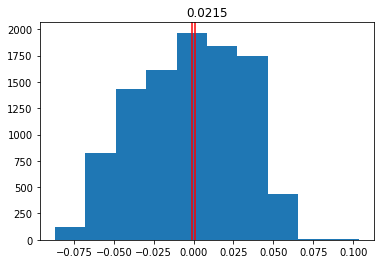

In [17]:
plt.axvline(z_tol, c='red')
plt.axvline(-z_tol, c='red')
plt.hist(train_dataset.zs - train_preds)
plt.title(K.eval(sci_standard(train_dataset.zs, train_preds)))
plt.show()

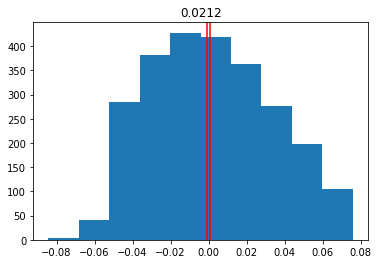

In [18]:
plt.axvline(z_tol, c='red')
plt.axvline(-z_tol, c='red')
plt.hist(val_preds - val_dataset.zs)
plt.title(K.eval(sci_standard(val_preds, val_dataset.zs)))
plt.show()